# Milestone 1

The objective of this project is to analyze the modelled daily rainfall dataset over NSW, Australia, spanning 1889- 2014. The dataset can be found [here](https://figshare.com/articles/dataset/Daily_rainfall_over_NSW_Australia/14096681). 

### Imports

In [1]:
import re
import os
import glob
import zipfile
import requests
from urllib.request import urlretrieve
import json
import pandas as pd
import dask
import dask.dataframe as dd
import seaborn as sns
import altair as alt

In [2]:
alt.renderers.enable('mimetype')

RendererRegistry.enable('mimetype')

### Variables

In [3]:
# Figshare article metadata
article_id = 14096681
url = f"https://api.figshare.com/v2/articles/{article_id}"
headers = {"Content-Type": "application/json"}
output_directory = "figsharerainfall"

### 3. Send API request to Figshare to download rainfall data 

We will download the data from [figshare](https://figshare.com/articles/dataset/Daily_rainfall_over_NSW_Australia/14096681) using [figshare API](https://docs.figshare.com/).

In [4]:
response = requests.request("GET", url, headers=headers)
data = json.loads(response.text)  # articles data
files = data["files"]             # list of files
files[3] # target file (data.zip)

{'id': 26766812,
 'name': 'data.zip',
 'size': 814041183,
 'is_link_only': False,
 'download_url': 'https://ndownloader.figshare.com/files/26766812',
 'supplied_md5': 'b517383f76e77bd03755a63a8ff83ee9',
 'computed_md5': 'b517383f76e77bd03755a63a8ff83ee9'}

### Collect data.zip folder from the list of `files` 

In [5]:
%%time
files_to_dl = ["data.zip"]
for file in files:
    if file["name"] in files_to_dl:
        os.makedirs(output_directory, exist_ok=True)
        # Download data.zip
        urlretrieve(file["download_url"], os.path.join(output_directory, file["name"]))

CPU times: user 4.25 s, sys: 7.61 s, total: 11.9 s
Wall time: 44.5 s


### Unzip files from `data.zip` folder

In [6]:
%%time
with zipfile.ZipFile(os.path.join(output_directory, "data.zip"), 'r') as f:
    f.extractall(os.path.join(output_directory, "data"))

CPU times: user 14.8 s, sys: 1.98 s, total: 16.8 s
Wall time: 19.1 s


### 4. Combining csv's in `data` folder

In [7]:
%%time
## merging files
files = glob.glob(os.path.join(output_directory, "data", "*.csv"))
# Exclude observed_daily_rainfall from our analysis
files = [file for file in files if file != os.path.join(output_directory, "data", "observed_daily_rainfall_SYD.csv")]
df = pd.concat((pd.read_csv(file, index_col=0) 
                .assign(model=re.findall(r'[^\/(\\)]+(?=\_daily_rainfall_NSW.csv)', file)[0])
                for file in files)
              )
df.to_csv(os.path.join(output_directory, "combined_data.csv"))

CPU times: user 5min 48s, sys: 17.5 s, total: 6min 5s
Wall time: 6min 16s


| Team Member       | Operating System | RAM  | Processor | Is SSD | Time taken |
|-------------------|------------------|------|-----------|--------|------------|
| Karanpreet Kaur   | windows           | 8 GB    | Processor 11th Gen Intel(R) Core(TM) i5     |       yes    |    11 min 12s  |            |
| Melisa Maidana    | mac              | 8 GB | M1        | yes    |   6 min 1s         |
| Nagraj Rao        | windows          |32 GB |AMD Ryzen 7 PRO 5850U with Radeon Graphics 1.90 GHz| yes        |   10 min 40s         |
| Ting Zhe (TZ) Yan | mac              | 8 GB | M1        | yes    |  6 min 23s          |

Comparing run times on different machines of our team members for combining csv's in the data folder reveals some interesting observations:

(i) Mac's seem to take less time than PC's and thereby more time efficient while combining csv's in the data folder. On average, there is a reduction of nearly 5 minutes by using Mac OS as opposed to Windows. 

(ii) Between the two Windows machines, the increase in RAM and difference in processor does not seem to impact the time taken very drastically. It has to be noted that this number is likely confounded by the number of parallel applications running on the two machines, which cannot be controlled for. 

In [8]:
%%sh
du -sh figsharerainfall/combined_data.csv

5.6G	figsharerainfall/combined_data.csv


In [9]:
print(df.shape)

(62467843, 6)


In [10]:
df.head()

,lat_min,lat_max,lon_min,lon_max,rain (mm/day),model
time,,,,,,
1889-01-01 12:00:00,-35.439867,-33.574619,141.5625,143.4375,4.244226e-13,MPI-ESM-1-2-HAM
1889-01-02 12:00:00,-35.439867,-33.574619,141.5625,143.4375,4.217326e-13,MPI-ESM-1-2-HAM
1889-01-03 12:00:00,-35.439867,-33.574619,141.5625,143.4375,4.498125e-13,MPI-ESM-1-2-HAM
1889-01-04 12:00:00,-35.439867,-33.574619,141.5625,143.4375,4.251282e-13,MPI-ESM-1-2-HAM
1889-01-05 12:00:00,-35.439867,-33.574619,141.5625,143.4375,4.270161e-13,MPI-ESM-1-2-HAM


### 5. Load the combined CSV to memory and perform a simple EDA

#### Combined Approach #1 & Approach # 2
_Loading only required columns and also change dtype of column `rain (mm/day)` while reading csv to reduce memory usage_

In [11]:
%%time
use_cols = ['rain (mm/day)', 'time']
df = pd.read_csv(os.path.join(output_directory, "combined_data.csv"), usecols=use_cols, index_col=False, 
                 dtype={'rain (mm/day)':'float32'})

CPU times: user 28.8 s, sys: 4.06 s, total: 32.9 s
Wall time: 36.2 s


In [12]:
# Memory usage
print(f"Memory usage with float32: {df.memory_usage().sum() / 1e6:.2f} MB")

Memory usage with float32: 749.61 MB


In [13]:
%%time
df['month'] = pd.to_datetime(df['time']).dt.month
df = df.groupby(['month'], as_index=False).agg({'rain (mm/day)':'mean'})

CPU times: user 10.5 s, sys: 2.49 s, total: 13 s
Wall time: 14.6 s


CPU times: user 9.97 ms, sys: 32.2 ms, total: 42.2 ms
Wall time: 56.6 ms


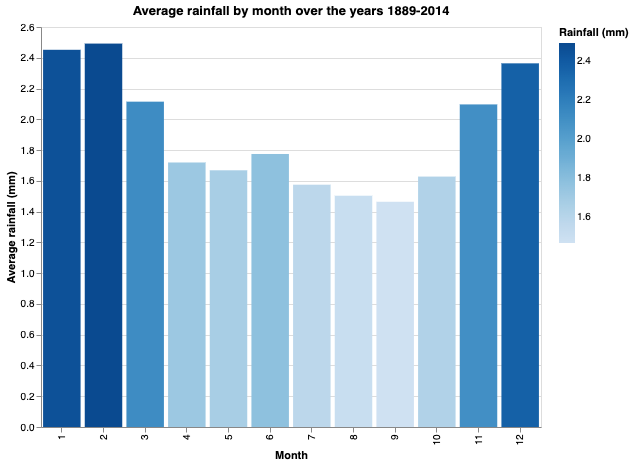

In [14]:
%%time
(alt.Chart(df, title='Average rainfall by month over the years 1889-2014')
    .encode(x=alt.X('month:O', title='Month'), 
            y=alt.Y('rain (mm/day)', title='Average rainfall (mm)'), 
            color=alt.Color('rain (mm/day)', title='Rainfall (mm)')).mark_bar()).properties(width=500, height=400)

| Team Member       | Operating System | RAM  | Processor | Is SSD | Time taken |
|-------------------|------------------|------|-----------|--------|------------|
| Karanpreet Kaur   | windows           | 8 GB    | Processor 11th Gen Intel(R) Core(TM) i5     |       yes    |   2 mins   |            |
| Melisa Maidana    | mac              | 8 GB | M1        | yes    |     53.65 s       |
| Nagraj Rao        |  windows         |32 GB |AMD Ryzen 7 PRO 5850U with Radeon Graphics 1.90 GHz| yes   |       2 mins 40s     |
| Ting Zhe (TZ) Yan | mac              | 8 GB | M1        | yes    |       57s     |

Comparing run times on different machines of our team members for loading the combined CSV to memory and performing simple EDA (Combined Approach 1 and 2) reveals some interesting observations:

(i) Mac's seem to take less time than PC's and thereby more time efficient while loading the CSV to memory and performing EDA. On average, there is a reduction of slightly over 1 minute by using Mac OS as opposed to Windows. 

(ii) Between the two Windows machines, the increase in RAM and difference in processor does not seem to play a role - in fact, the machine with greater RAM took slightly longer. It has to be noted that this number is likely confounded by the number of parallel applications running on the two machines, which cannot be controlled for. 

#### Approach #2

Next, we will use [Dask](https://dask.org/) to load our data and do some simple aggregation.

In [15]:
%%time
# Read csv as Dask dataframe
ddf = dd.read_csv('figsharerainfall/combined_data.csv', usecols=use_cols, parse_dates=["time"])

CPU times: user 6.06 ms, sys: 6.61 ms, total: 12.7 ms
Wall time: 24.5 ms


In [16]:
%%time
ddf['month'] = ddf['time'].dt.month
ddf = ddf.groupby(['month']).agg({'rain (mm/day)':'mean'}).compute()
ddf = ddf.reset_index()

CPU times: user 48.1 s, sys: 10.1 s, total: 58.2 s
Wall time: 28.8 s


CPU times: user 9.17 ms, sys: 2.74 ms, total: 11.9 ms
Wall time: 12 ms


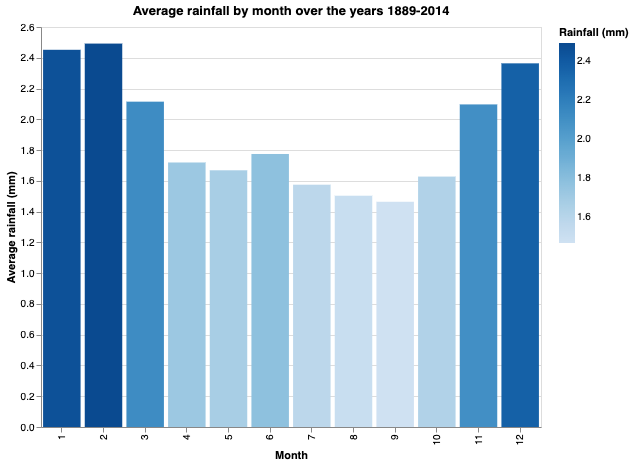

In [17]:
%%time
(alt.Chart(ddf, title='Average rainfall by month over the years 1889-2014')
    .encode(x=alt.X('month:O', title='Month'), 
            y=alt.Y('rain (mm/day)', title='Average rainfall (mm)'), 
            color=alt.Color('rain (mm/day)', title='Rainfall (mm)')).mark_bar()).properties(width=500, height=400)

| Team Member       | Operating System | RAM  | Processor | Is SSD | Time taken |
|-------------------|------------------|------|-----------|--------|------------|
| Karanpreet Kaur   | windows           | 8 GB    | Processor 11th Gen Intel(R) Core(TM) i5     |       yes    |   1 min 30 s   |            |
| Melisa Maidana    | mac              | 8 GB | M1        | yes    |     31.03 s       |
| Nagraj Rao        | windows          |32 GB | AMD Ryzen 7 PRO 5850U with Radeon Graphics 1.90 GHz| yes |         3 min 25 s   |
| Ting Zhe (TZ) Yan | mac              | 8 GB | M1        | yes    |   34s         |

Comparing run times on different machines of our team members for loading the combined CSV to memory and performing simple EDA (Approach 2) reveals some interesting observations:

(i) Mac's seem to take less time than PC's and thereby more time efficient while loading the CSV to memory and performing EDA. On average, Mac OS is 5 times more time efficient. 

(ii) Between the two Windows machines, the increase in RAM and difference in processor has an opposite effect - the machine with greater RAM took more than double the time. It has to be noted that this number is likely confounded by the number of parallel applications running on the two machines, which cannot be controlled for. 

### 6. Perform a simple EDA in R

#### Approach to transfer the dataframe from python to R

In [18]:
%load_ext rpy2.ipython

Time difference of 0.596272 secs


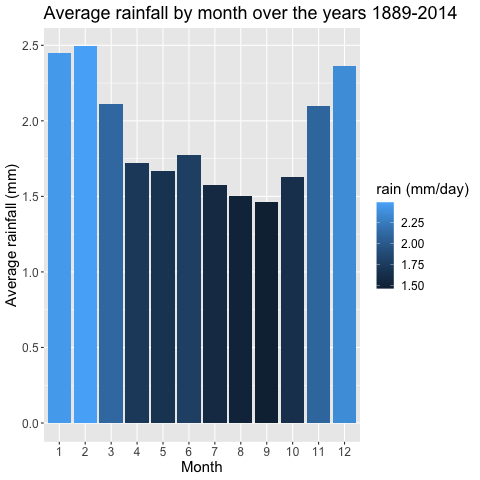

CPU times: user 586 ms, sys: 140 ms, total: 726 ms
Wall time: 1.68 s


In [19]:
%%time
%%R -i df
start_time <- Sys.time()
suppressMessages(library(dplyr))
suppressMessages(library(ggplot2))
p <- ggplot(df, aes(x=as.factor(month), y=`rain (mm/day)`, fill=`rain (mm/day)`)) +
     geom_bar(stat='identity') +
     labs(x = 'Month', y='Average rainfall (mm)', title='Average rainfall by month over the years 1889-2014') +
    theme(text=element_text(size=15))
    
end_time <- Sys.time()
print(p)
print(end_time - start_time)

#### Discuss why you chose this approach over others

Our team used `arrow exchange` over other three methods (Parquet file, Feather file, Pandas exchange) for several reasons:

(i) We had already selected desired columns and carried out wrangling for EDA in pandas dataframe. So, it made more sense to use arrow exchange instead of having csv read as parquet or feather file and again do same wrangling.

(ii) We also found installation for arrow exchange to be easy. 

(iii) Paraquet and Feather require re-loading of the data, which we were able to avoid by arrow exchange. We also opted for this method since it reduces time spent during serialization and de-serialization alongside not creating unnecessary copies of the data. 

(iv) A quick search online also showed us that arrow exchange also allows access to dplyr functions. 

(v) While not a drastic decision-making factor, the files in arrow exchange were stored in a format that was slightly less memory-intensive compared to the other methods. One can imagine how this could be of huge savings if we are working with big data! 

(vi) While Feather seemed promising, it is still in its development phase, so there may be some unintended bugs, and is not optimal for long-term storage suitability. Paraquet is mainly useful for archival storage purpose, and therefore may not be the best solution. 

#### Summary of results

| Team Member       | Operating System | RAM  | Processor | Is SSD | Time taken |
|-------------------|------------------|------|-----------|--------|------------|
| Karanpreet Kaur   | windows           | 8 GB    | Processor 11th Gen Intel(R) Core(TM) i5     |       yes    |   1.13 secs  |            |
| Melisa Maidana    | mac              | 8 GB | M1        | yes    |     2 s       |
| Nagraj Rao        | windows          |32 GB |AMD Ryzen 7 PRO 5850U with Radeon Graphics 1.90 GHz| yes | 1.14 secs            |
| Ting Zhe (TZ) Yan | mac              | 8 GB | M1        | yes    |       1.85s     |

Comparing run times on different machines of our team members for performing simple EDA in R reveals some interesting observations:

(i) Here, there is some evidence on time efficiency of PC's relative to Mac's, by nearly 70%. Both MAC's took significantly higher time. 

(ii) Between the two Windows machines, the increase in RAM and difference in processor does not seem to play a role. It has to be noted that this number is likely confounded by the number of parallel applications running on the two machines, which cannot be controlled for. 

#### Challenges

**Discuss any challenges or difficulties you faced when dealing with this large amount of data on your laptops. Briefly explain your approach to overcome the challenges or reasons why you could not overcome them.**


(i) Since our team has two Mac and PC users, we initially had some challenge getting the code pertaining with forward versus double backslash. It also took a few iterations of the RegEx to work due to slight differences in the OS's implementation. To resolve this problem, we used os.path.join to manage the file path and enhanced the regular expression to consider both operating systems.

(ii) Collaboration on Jupyter notebook required some extra coordination. To overcome this issue, we broke down the milestone in tasks that were executed sequentially by the different team members and strove for effective communication regarding progress of tasks, challenges faced and assistance required.